# Text Mining for Toxic Comments: Topic Modeling

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 36.4 MB/s eta 0:00:00


In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.3 MB/s eta 0:00:00


In [ ]:
# General
import gdown
import zipfile
import os
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import html
from pprint import pprint

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('wordnet')

# General Topic Modeling
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity

# LDA
from gensim.models import LdaModel, LdaMulticore
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# BERTopic
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# Fix seeds for LDA
np.random.seed(42)

In [ ]:
url = 'https://drive.google.com/uc?id=1GV_kAxXAd2lQgwUUQwuRf4CL0MO1_hfR'
# If file not exists, make dir
if not os.path.exists('/content/data'):
    os.mkdir('/content/data')
output = 'jigsaw-toxic-comment-classification-challenge.zip'
gdown.download(url, output, quiet=False)

zip_file = zipfile.ZipFile('jigsaw-toxic-comment-classification-challenge.zip')
zip_file.extractall('data/')
zip_file.close()
os.remove('jigsaw-toxic-comment-classification-challenge.zip')

# Extract all files with .zip in the content folder
for file in os.listdir('/content/data'):
  if file.endswith('.zip'):
    zip_file = zipfile.ZipFile('/content/data/' + file)
    zip_file.extractall('/content/data/')
    zip_file.close()
    os.remove('/content/data/' + file)

Downloading...
From (original): https://drive.google.com/uc?id=1GV_kAxXAd2lQgwUUQwuRf4CL0MO1_hfR
From (redirected): https://drive.google.com/uc?id=1GV_kAxXAd2lQgwUUQwuRf4CL0MO1_hfR&confirm=t&uuid=05d5da88-1817-4264-b236-2caed72f6a0e
To: /content/jigsaw-toxic-comment-classification-challenge.zip
100%|██████████| 55.2M/55.2M [00:01<00:00, 30.5MB/s]


# Preparation
In this phase:
- we import data from the `.csv` files;
- we filter out the clean comments, keeping only the comments with at least one active (=1) label;
- we concatenate train and test data to obtain more comments to build the model on.

In [ ]:
# Import Data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')['comment_text']
y_test = pd.read_csv('data/test_labels.csv').drop(columns = 'id')

In [ ]:
# Get only "Not Clean" comments (i.e., comments with at least one "1" in any label)
toxic_comments_index = train[train.iloc[:, 2:].sum(axis = 1) >= 1].index
train = train.iloc[toxic_comments_index]['comment_text']

toxic_comments_index = y_test[y_test.sum(axis = 1) >= 1].index
test = test.iloc[toxic_comments_index].reset_index(drop = True)

In [ ]:
# Concatenating datasets
full = pd.concat([train, test], ignore_index=True)

In [ ]:
print(f'We have {full.shape[0]} comments')

We have 22468 comments


# LDA


## Evaluation Function

In [ ]:
def evaluate_model(model, docs, compute_perplexity = False):
  # Coherence
  print('--- Computing Coherence ---')
  coherencemodel = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
  print(f"Coherence: {coherencemodel.get_coherence():4f}\n")

  # Perplexity
  if compute_perplexity:
    print('--- Computing Perplexity ---')
    log_pp = model.log_perplexity(corpus)
    print(f"Log Perplexity (cross-entropy): {log_pp:.4f}")
    pp = np.exp(log_pp)
    print(f"Perplexity: {pp:.4f}\n")

  # Diversity
  print('--- Computing Diversity ---')
  topics = model.show_topics(num_topics=-1, formatted=False)
  all_top_words = []
  for topic_id, word_list in topics:
      for word, prob in word_list:
          all_top_words.append(word)
  unique_words = set(all_top_words)
  diversity = len(unique_words) / len(all_top_words)

  print(f"Lexical Diversity (Top 10 words): {diversity:.4f}")

## Preprocessing

In [ ]:
nltk.download('stopwords', quiet=True)

def tfidf_preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Decode HTML and Remove Tags
    text = html.unescape(text)
    text = re.sub(r'<.*?>', '', text)

    # Mask/Remove URLs and Users
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+|user:\w+', '', text)

    # Remove IP Addresses
    text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', text)

    # Remove Numbers
    text = re.sub(r'\d+', '', text)

    # Remove Punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove Character Repetitions
    pattern_alpha = re.compile(r"([A-Za-z])\1{2,}", re.DOTALL)
    text = pattern_alpha.sub(r"\1\1", text)

    # Final cleanup which removes Double Whitespaces, Newlines, Tabs
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Create a custom list of stopwords
stop_words = set(stopwords.words('english'))
# Add wikipedia's terms as stopwords
stop_words.update(['page',
                   'like',
                   'wikipedia',
                   'article'
                   ])

lemmatizer = WordNetLemmatizer()

def lemmatizer_and_stopwords(tokens):
    return [
        lemmatizer.lemmatize(t)
        for t in tokens
        if t.lower() not in stop_words and len(t) > 2
    ]


# Combining preprocessor and lemmatizer
def clean_text(text, lemmatization = True):
    # Preprocessing
    text = tfidf_preprocess_text(text)

    # Tokenization
    tokens = word_tokenize(text)

    # Lemmatization
    if lemmatization:
      tokens = lemmatizer_and_stopwords(tokens)

    return tokens

In [ ]:
docs = full.apply(clean_text, lemmatization=True)

docs[:5]

,comment_text
0,"[cocksucker, piss, around, work]"
1,"[hey, talk, exclusive, group, taliban, good, d..."
2,"[bye, look, come, think, comming, back, tosser]"
3,"[gay, antisemmitian, archangel, white, tiger, ..."
4,"[fuck, filthy, mother, as, dry]"


## Dictionary

In [ ]:
# Getting the corpus dictionary
dictionary = Dictionary(docs)

# Filter Extreme Words
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [ ]:
# Get list of tokens in the dictionary
tokens = [dictionary[i] for i in range(len(dictionary))]

In [ ]:
print('Number of unique tokens: %d' % len(dictionary))

Number of unique tokens: 7183


In [ ]:
# Get a Bag of Words (BoW) Representation
corpus = [dictionary.doc2bow(doc) for doc in docs]
# Print First Document Representation
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1)]

 ## Models

We'll define a custom Grid Search to try some combinations of hyperparameters, in order to see how much the coherence changes between different models.

In [ ]:
passes = 10

for i in [5, 10]:
  for a in ['symmetric', 'asymmetric']:
    for e in ['auto', 'symmetric']:
      print(f'num_topics: {i}, alpha: {a}, eta: {e}')

      model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        alpha=a,
        eta=e,
        num_topics=i,
        passes=passes,
        random_state=42
      )

      evaluate_model(model, docs, compute_perplexity = True)

      print("**************")

num_topics: 5, alpha: symmetric, eta: auto
--- Computing Coherence ---
Coherence: 0.503704

--- Computing Perplexity ---
Log Perplexity (cross-entropy): -6.8806
Perplexity: 0.0010

--- Computing Diversity ---
Lexical Diversity (Top 10 words): 0.9600
**************
num_topics: 5, alpha: symmetric, eta: symmetric
--- Computing Coherence ---
Coherence: 0.520521

--- Computing Perplexity ---
Log Perplexity (cross-entropy): -6.8915
Perplexity: 0.0010

--- Computing Diversity ---
Lexical Diversity (Top 10 words): 0.9800
**************
num_topics: 5, alpha: asymmetric, eta: auto
--- Computing Coherence ---
Coherence: 0.483788

--- Computing Perplexity ---
Log Perplexity (cross-entropy): -6.9067
Perplexity: 0.0010

--- Computing Diversity ---
Lexical Diversity (Top 10 words): 0.9800
**************
num_topics: 5, alpha: asymmetric, eta: symmetric
--- Computing Coherence ---
Coherence: 0.505752

--- Computing Perplexity ---
Log Perplexity (cross-entropy): -6.8483
Perplexity: 0.0011

--- Computin

We obtained the best results, in terms of coherence and diversity, using `alpha` and `eta` both set to `"symmetric"` with 5 topics; this seems to suggest that both document-topic distribution and word-topic distribution are quite symmetric in our data, and that 5 is a good number of topics for our documents.

### 10 Topics

In [ ]:
model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        alpha="symmetric",
        eta="symmetric",
        num_topics=10,
        passes=20,
        random_state=42,
        per_word_topics=True
      )

In [ ]:
pprint(model.print_topics())

[(0,
  '0.283*"nigger" + 0.136*"cunt" + 0.091*"bitch" + 0.067*"stupid" + '
  '0.058*"fat" + 0.039*"jew" + 0.039*"whore" + 0.031*"slut" + 0.023*"fuk" + '
  '0.020*"calvin"'),
 (1,
  '0.222*"fucking" + 0.131*"shit" + 0.047*"kill" + 0.043*"ball" + 0.030*"homo" '
  '+ 0.024*"bullshit" + 0.022*"curps" + 0.021*"going" + 0.019*"piece" + '
  '0.019*"naconkantari"'),
 (2,
  '0.222*"suck" + 0.153*"gay" + 0.152*"dick" + 0.050*"cock" + 0.039*"aid" + '
  '0.021*"know" + 0.018*"lick" + 0.018*"little" + 0.016*"kid" + 0.016*"twat"'),
 (3,
  '0.011*"get" + 0.009*"people" + 0.009*"one" + 0.008*"know" + 0.008*"think" + '
  '0.007*"stupid" + 0.007*"idiot" + 0.006*"time" + 0.006*"make" + '
  '0.006*"would"'),
 (4,
  '0.049*"moron" + 0.042*"please" + 0.015*"racist" + 0.013*"black" + '
  '0.012*"image" + 0.012*"vandalize" + 0.012*"country" + 0.010*"nazi" + '
  '0.010*"still" + 0.010*"world"'),
 (5,
  '0.162*"hate" + 0.080*"fag" + 0.036*"love" + 0.036*"loser" + '
  '0.027*"lolololol" + 0.025*"wiki" + 0.024*"h

In [ ]:
evaluate_model(model, docs, compute_perplexity = True)

--- Computing Coherence ---
Coherence: 0.515262

--- Computing Perplexity ---
Log Perplexity (cross-entropy): -6.7896
Perplexity: 0.0011

--- Computing Diversity ---
Lexical Diversity (Top 10 words): 0.9700


In [ ]:
# Initialize a list to hold the dominant topic for each document
dominant_topics = []

# Iterate over the corpus using the model
for i, row in enumerate(model[corpus]):

    # Handle the output format based on per_word_topics setting
    if model.per_word_topics:
        row = row[0]  # The topic distribution is the first element
    row = sorted(row, key=lambda x: x[1], reverse=True)

    # Get the dominant topic (first element after sorting)
    dominant_topic = row[0][0]
    dominant_prob = row[0][1]

    dominant_topics.append((i, dominant_topic, dominant_prob))

# Create a DataFrame
df_topics = pd.DataFrame(dominant_topics, columns=['Document_ID', 'Dominant_Topic', 'Probability'])

print(df_topics.head())

   Document_ID  Dominant_Topic  Probability
0            0               3     0.619954
1            1               3     0.747488
2            2               3     0.871364
3            3               3     0.506231
4            4               9     0.516634


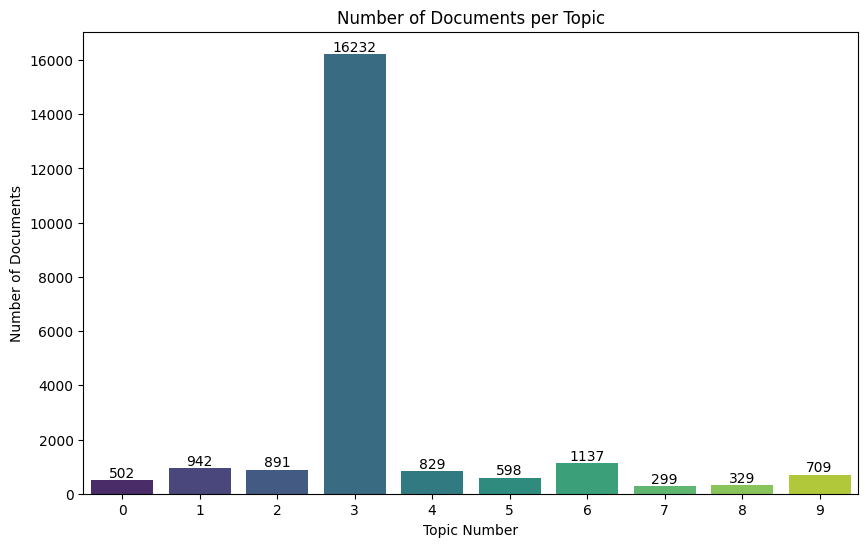

In [ ]:
import seaborn as sns

# Calculate counts
topic_counts = df_topics['Dominant_Topic'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.title('Number of Documents per Topic')
plt.xticks(ticks=range(model.num_topics)) # Ensure all topic numbers are shown
for i, v in enumerate(topic_counts.values):
    ax.text(i, v + 100, str(v), ha='center')

plt.show()

In [ ]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
# Convert to Array
arr = pd.DataFrame(topic_weights).fillna(0).values
# Keep the well separated points
arr = arr[np.amax(arr, axis=1) > 0.35]

# Get dominant topic number in each document
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10

# Generate a palette with 10 colors and convert to hex codes
palette = sns.color_palette("tab10", n_topics).as_hex()
mycolors = np.array(palette)

# Plot
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics))
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20648 samples in 0.047s...
[t-SNE] Computed neighbors for 20648 samples in 1.871s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20648
[t-SNE] Computed conditional probabilities for sample 2000 / 20648
[t-SNE] Computed conditional probabilities for sample 3000 / 20648
[t-SNE] Computed conditional probabilities for sample 4000 / 20648
[t-SNE] Computed conditional probabilities for sample 5000 / 20648
[t-SNE] Computed conditional probabilities for sample 6000 / 20648
[t-SNE] Computed conditional probabilities for sample 7000 / 20648
[t-SNE] Computed conditional probabilities for sample 8000 / 20648
[t-SNE] Computed conditional probabilities for sample 9000 / 20648
[t-SNE] Computed conditional probabilities for sample 10000 / 20648
[t-SNE] Computed conditional probabilities for sample 11000 / 20648
[t-SNE] Computed conditional probabilities for sample 12000 / 20648
[t-SNE] Computed conditional probabilities for sam

### 5 Topics

In [ ]:
model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        alpha="symmetric",
        eta="auto",
        num_topics=5,
        passes=20,
        random_state=42,
        per_word_topics=True # For later Visualizations
      )

In [ ]:
pprint(model.print_topics())

[(0,
  '0.258*"fuck" + 0.133*"nigger" + 0.072*"bitch" + 0.064*"cunt" + '
  '0.031*"penis" + 0.030*"stupid" + 0.028*"bastard" + 0.027*"fat" + '
  '0.022*"motherfucker" + 0.018*"jew"'),
 (1,
  '0.143*"fucking" + 0.084*"shit" + 0.077*"faggot" + 0.065*"as" + 0.030*"kill" '
  '+ 0.030*"boob" + 0.028*"ball" + 0.027*"fucker" + 0.023*"mother" + '
  '0.020*"nigga"'),
 (2,
  '0.127*"suck" + 0.087*"gay" + 0.087*"dick" + 0.086*"hate" + 0.032*"sex" + '
  '0.028*"cock" + 0.019*"love" + 0.016*"fuk" + 0.013*"know" + 0.012*"france"'),
 (3,
  '0.011*"get" + 0.009*"people" + 0.008*"one" + 0.008*"know" + 0.007*"stupid" '
  '+ 0.007*"think" + 0.007*"idiot" + 0.006*"stop" + 0.006*"time" + '
  '0.006*"make"'),
 (4,
  '0.065*"die" + 0.031*"fag" + 0.024*"poop" + 0.022*"moron" + 0.016*"must" + '
  '0.015*"vandal" + 0.013*"shut" + 0.012*"asshole" + 0.012*"bum" + '
  '0.011*"traitor"')]


In [ ]:
evaluate_model(model, docs, compute_perplexity = True)

--- Computing Coherence ---
Coherence: 0.514267

--- Computing Perplexity ---
Log Perplexity (cross-entropy): -6.8756
Perplexity: 0.0010

--- Computing Diversity ---
Lexical Diversity (Top 10 words): 0.9600


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a list to hold the dominant topic for each document
dominant_topics = []

# Iterate over the corpus using the model
for i, row in enumerate(model[corpus]):

    # Handle the output format based on per_word_topics setting
    if model.per_word_topics:
        row = row[0]  # The topic distribution is the first element
    row = sorted(row, key=lambda x: x[1], reverse=True)

    # Get the dominant topic (first element after sorting)
    dominant_topic = row[0][0]
    dominant_prob = row[0][1]

    dominant_topics.append((i, dominant_topic, dominant_prob))

# Create a DataFrame
df_topics = pd.DataFrame(dominant_topics, columns=['Document_ID', 'Dominant_Topic', 'Probability'])

print(df_topics.head())

   Document_ID  Dominant_Topic  Probability
0            0               3     0.839720
1            1               3     0.906016
2            2               3     0.885635
3            3               3     0.463298
4            4               1     0.366814


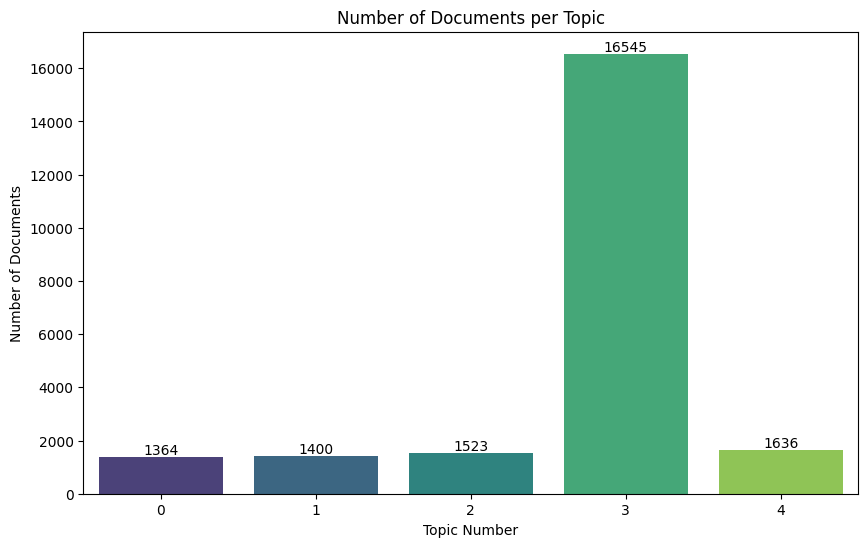

In [ ]:
import seaborn as sns

# Calculate counts
topic_counts = df_topics['Dominant_Topic'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.title('Number of Documents per Topic')
plt.xticks(ticks=range(model.num_topics)) # Ensure all topic numbers are shown
for i, v in enumerate(topic_counts.values):
    ax.text(i, v + 100, str(v), ha='center')

plt.show()

In [ ]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
# Convert to Array
arr = pd.DataFrame(topic_weights).fillna(0).values
# Keep the well separated points
arr = arr[np.amax(arr, axis=1) > 0.35]

# Get dominant topic number in each document
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5

# Generate a palette with 10 colors and convert to hex codes
palette = sns.color_palette("tab10", n_topics).as_hex()
mycolors = np.array(palette)

# Plot
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics))
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 21800 samples in 0.018s...
[t-SNE] Computed neighbors for 21800 samples in 0.736s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21800
[t-SNE] Computed conditional probabilities for sample 2000 / 21800
[t-SNE] Computed conditional probabilities for sample 3000 / 21800
[t-SNE] Computed conditional probabilities for sample 4000 / 21800
[t-SNE] Computed conditional probabilities for sample 5000 / 21800
[t-SNE] Computed conditional probabilities for sample 6000 / 21800
[t-SNE] Computed conditional probabilities for sample 7000 / 21800
[t-SNE] Computed conditional probabilities for sample 8000 / 21800
[t-SNE] Computed conditional probabilities for sample 9000 / 21800
[t-SNE] Computed conditional probabilities for sample 10000 / 21800
[t-SNE] Computed conditional probabilities for sample 11000 / 21800
[t-SNE] Computed conditional probabilities for sample 12000 / 21800
[t-SNE] Computed conditional probabilities for sam

In [ ]:
# Extend Stopwords with "Generic" Toxicity (these words are 'noise' because they don't define a specific TYPE of hate, just hate in general)
new_stops = ['fuck', 'fucking', 'fucker', 'shit', 'suck', 'bitch', 'ass',
             'like', 'know', 'think', 'get', 'would', 'one']
stop_words.update(new_stops)

# Redefine our text
docs_refined = [[word for word in doc if word not in new_stops] for doc in docs]

# Create Dictionary
dictionary = Dictionary(docs_refined)

# Filter Extreme Words
dictionary.filter_extremes(no_below=10, no_above=0.15)

# Get Corpus
corpus = [dictionary.doc2bow(text) for text in docs_refined]

In [ ]:
# Train the New Model
model = LdaMulticore(corpus=corpus, num_topics=5, id2word=dictionary, passes=20, random_state=42, per_word_topics=True )

In [ ]:
from pprint import pprint
pprint(model.print_topics())

[(0,
  '0.381*"nigger" + 0.042*"aid" + 0.026*"night" + 0.023*"pig" + '
  '0.023*"dickhead" + 0.022*"france" + 0.020*"dumbass" + 0.020*"shitty" + '
  '0.018*"fuckin" + 0.017*"fucked"'),
 (1,
  '0.099*"faggot" + 0.093*"hate" + 0.062*"stupid" + 0.039*"kill" + '
  '0.031*"cock" + 0.023*"bullshit" + 0.023*"love" + 0.017*"cheese" + '
  '0.017*"freedom" + 0.014*"huge"'),
 (2,
  '0.102*"cunt" + 0.093*"die" + 0.091*"dick" + 0.050*"penis" + 0.043*"fat" + '
  '0.033*"sex" + 0.032*"moron" + 0.029*"jew" + 0.029*"whore" + 0.025*"nigga"'),
 (3,
  '0.016*"gay" + 0.010*"people" + 0.006*"time" + 0.006*"make" + 0.005*"say" + '
  '0.005*"stupid" + 0.005*"stop" + 0.005*"idiot" + 0.005*"asshole" + '
  '0.005*"even"'),
 (4,
  '0.082*"as" + 0.048*"hell" + 0.046*"fag" + 0.038*"motherfucker" + '
  '0.038*"boob" + 0.036*"poop" + 0.035*"ball" + 0.032*"bastard" + '
  '0.029*"mother" + 0.024*"hole"')]


In [ ]:
evaluate_model(model, docs_refined, compute_perplexity = True)

--- Computing Coherence ---
Coherence: 0.482848

--- Computing Perplexity ---
Log Perplexity (cross-entropy): -6.8755
Perplexity: 0.0010

--- Computing Diversity ---
Lexical Diversity (Top 10 words): 0.9800


# NMF

## Evaluation Function

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TF-IDF ignoring words in >95% of docs and words in <2 docs
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform([' '.join(doc) for doc in docs_refined])

def evaluate_nmf_model(nmf_model, vectorizer, tokenized_texts, top_n=10):
    # Extract NMF Topics
    feature_names = vectorizer.get_feature_names_out()

    topics_list = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        # Get indices of top words
        top_indices = topic.argsort()[:-top_n - 1:-1]
        # Get actual words
        top_words = [feature_names[i] for i in top_indices]
        topics_list.append(top_words)


    # Compute Coherence (C_v)
    print('--- Computing Coherence ---')
    dictionary = Dictionary(tokenized_texts)
    cm = CoherenceModel(topics=topics_list,
                        texts=tokenized_texts,
                        dictionary=dictionary,
                        coherence='c_v')
    print(f'Coherence: {cm.get_coherence():.4f}\n')

    # Compute Reconstruction Error (NMF's version of Perplexity)
    print('--- Computing Reconstruction Error (NMF\'s version of Perplexity) ---')
    print(f'Reconstruction Error: {nmf_model.reconstruction_err_:.4f}\n')

    # Compute Topic Diversity (Lexical)
    print('--- Computing Diversity ---')
    all_top_words = [word for topic in topics_list for word in topic[:10]]
    unique_top_words = set(all_top_words)
    print(f'Lexical Diversity (Top 10 Words): {len(unique_top_words) / len(all_top_words):.4f}\n')


## Model

## 10 Topics

In [ ]:
from sklearn.decomposition import NMF


# Run NMF
nmf_model = NMF(n_components=10, random_state=42, init='nndsvd').fit(tfidf)

# Get Topics
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_idx}:")
    # Print top 10 words per topic
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
    print("-" * 20)

Topic 0:
stop people talk life want please time make edit block
--------------------
Topic 1:
gay fag sex homo guy porn love penis soo really
--------------------
Topic 2:
dick big eat head cock pussy fag nigger love hey
--------------------
Topic 3:
asshole hey hell mother son shut motherfucker fuckin piece die
--------------------
Topic 4:
idiot call delete read vandalism shut block vandal understand complete
--------------------
Topic 5:
stupid dumb really people shut retard thing bot look idea
--------------------
Topic 6:
cunt mother nigger die fat whore bastard block eat kill
--------------------
Topic 7:
faggot nigger shut hey huge cock delete little cocksucking die
--------------------
Topic 8:
as hole cock dumb kiss fat mother pussy penis fuckin
--------------------
Topic 9:
hate die kill guy nigger much gut god hope people
--------------------


In [ ]:
evaluate_nmf_model(nmf_model, tfidf_vectorizer, docs_refined)

--- Computing Coherence ---
Coherence: 0.4569

--- Computing Reconstruction Error (NMF's version of Perplexity) ---
Reconstruction Error: 145.6265

--- Computing Diversity ---
Lexical Diversity (Top 10 Words): 0.6900



## 5 Topics

In [ ]:
from sklearn.decomposition import NMF

# Run NMF
nmf_model = NMF(n_components=5, random_state=42, init='nndsvd').fit(tfidf)

# Get Topics
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_idx}:")
    # Print top 10 words per topic
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
    print("-" * 20)

Topic 0:
stupid people stop talk life want as please time make
--------------------
Topic 1:
gay faggot as fag sex homo guy nigger penis porn
--------------------
Topic 2:
dick as faggot big cock eat nigger pussy head fat
--------------------
Topic 3:
asshole cunt hey mother hell son motherfucker shut fuckin die
--------------------
Topic 4:
idiot vandalism call read delete block vandal understand called complete
--------------------


In [ ]:
evaluate_nmf_model(nmf_model, tfidf_vectorizer, docs_refined)

--- Computing Coherence ---
Coherence: 0.4900

--- Computing Reconstruction Error (NMF's version of Perplexity) ---
Reconstruction Error: 147.1227

--- Computing Diversity ---
Lexical Diversity (Top 10 Words): 0.9200



# Bertopic

### Preprocessor

In [ ]:
def bertopic_preprocessor(text):
    # Decode HTML entities ("&amp;" -> "&", "&quot;" -> '"')
    text = html.unescape(text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Mask URLs with 'http'
    text = re.sub(r'http\S+|www\S+', 'http', text)

    # Remove IP Addresses
    text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', text)

    # Mask tag/mention with 'user'
    text = re.sub(r'@\w+', 'user', text)

    # Remove Character Repetitions
    pattern_alpha = re.compile(r"([A-Za-z])\1{2,}", re.DOTALL)
    text = pattern_alpha.sub(r"\1\1", text)

    # Final cleanup which removes Double Whitespaces, Newlines, Tabs
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
full_bt = full.apply(bertopic_preprocessor)

## Quantitative Evaluation
We'll define a function we'll use to evaluate our topic models:

In [ ]:
# Tokenize documents (We need this for the Gensim Dictionary)
def simple_tokenize(sentences):
    return [sent.split() for sent in sentences]

# Use the same docs fed into BERTopic
tokenized_docs = simple_tokenize(full_bt)

# Create Gensim Dictionary
id2word = Dictionary(tokenized_docs)

# Evaluation Function
def evaluate_bertopic(topic_model, tokenized_docs, dictionary):
    # Prepare Topics
    topic_info = topic_model.get_topics()
    topics_list = []

    # Extract words for Coherence/Lexical Diversity
    for topic_id, words_probs in topic_info.items():
        if topic_id != -1:  # Ignore outliers
            words = [word for word, prob in words_probs]
            topics_list.append(words)

    if not topics_list:
        print("Error: No topics found (all data might be outliers).")
        return

    # Calculate Coherence (C_v)
    print("Calculating Coherence...")
    cm = CoherenceModel(topics=topics_list,
                        texts=tokenized_docs,
                        dictionary=dictionary,
                        coherence='c_v')
    coherence_cv = cm.get_coherence()

    # Calculate Semantic Diversity (Embedding Distance)
    print("Calculating Semantic Diversity...")

    # Get Topic Info and align with Embeddings
    info_df = topic_model.get_topic_info()

    # Filter for valid topics (Topic != -1)
    valid_mask = info_df['Topic'] != -1
    valid_indices = info_df[valid_mask].index

    if len(valid_indices) > 1:
        # Retrieve embeddings for valid topics only
        valid_embeddings = np.array(topic_model.topic_embeddings_)[valid_indices]

        # Compute Cosine Similarity
        sim_matrix = cosine_similarity(valid_embeddings)

        # Average Similarity (ignoring diagonal self-similarity)
        np.fill_diagonal(sim_matrix, np.nan)
        avg_similarity = np.nanmean(sim_matrix)

        semantic_diversity = 1 - avg_similarity
    else:
        semantic_diversity = 0.0
        print("Warning: Not enough topics to calculate semantic diversity.")

    # Print Results
    print(f"\n--- BERTopic Evaluation ---")
    print(f"Coherence (C_v):       {coherence_cv:.4f}  (Higher is better)")
    print(f"Semantic Diversity:    {semantic_diversity:.4f}  (Higher is better)")

## Topic Fine-Tuning

In [ ]:
# KeyBERT + MMR for Topic Fine-Tuning
representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "MMR": MaximalMarginalRelevance(diversity=0.3),
    "Main": KeyBERTInspired()
}

## Clustering with HDBSCAN

In [ ]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(full_bt, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/703 [00:00<?, ?it/s]

In [ ]:
# Vectorizer to remove stopwords
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))
custom_stopwords = list(CountVectorizer(stop_words="english").get_stop_words())
custom_stopwords.extend(["don", "just", "like", "know", "people", "think", "did", "going"])

vectorizer_model = CountVectorizer(
    stop_words=custom_stopwords,
    ngram_range=(1, 2)
)

In [ ]:
# UMAP for Dimensionality Reduction
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# HDBSCAN for Clustering
hdbscan_model = HDBSCAN(min_cluster_size=100, min_samples = 5, cluster_selection_epsilon=0.15, metric='euclidean', cluster_selection_method='eom')

# Model Initialization
topic_model = BERTopic(
    embedding_model = sentence_model,
    nr_topics=None,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model
)

topics, probs = topic_model.fit_transform(documents = full_bt, embeddings = embeddings)

In [ ]:
topic_model.update_topics(full_bt, representation_model = representation_model)

In [ ]:
evaluate_bertopic(topic_model, tokenized_docs, id2word)

Calculating Coherence...
Calculating Semantic Diversity...

--- BERTopic Evaluation ---
Coherence (C_v):       0.3666  (Higher is better)
Semantic Diversity:    0.5277  (Higher is better)


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,8689,-1_stop_what_talk_page,"[stop, what, talk, page, block, you, about, yo...","[stop, what, talk, page, block, you, about, yo...","[your, in, hi, moron, be, he, what, will, as, if]","["" fuck you bastard. consider this your last w..."
1,0,1361,0_wikipedia_encyclopedia_wiki_articles,"[wikipedia, encyclopedia, wiki, articles, hate...","[wikipedia, encyclopedia, wiki, articles, hate...","[wikipedia, to, and, on, me, be, wiki, my, don...",[and F*** WIKIPEDIA HAHAHAHAHAHAHAAHAHAHAA!!! ...
2,1,1227,1_poop_poo_fart_anal,"[poop, poo, fart, anal, smell, vagina, penis, ...","[poop, poo, fart, anal, smell, vagina, penis, ...","[poop, penis, suck, my, cock, vagina, balls, s...","[then I guess I eat poop, As it happens, Jonat..."
3,2,826,2_gay_homosexual_homosexuality_gays,"[gay, homosexual, homosexuality, gays, queer, ...","[gay, homosexual, homosexuality, gays, queer, ...","[gay, naconkantari, lolololol, homo, homosexua...","[i think he was gay Well was he?, GAY GAY GAY ..."
4,3,752,3_blocked_blocking_ban_block,"[blocked, blocking, ban, block, banned, ip, st...","[blocked, blocking, ban, block, banned, ip, st...","[blocked, block, ip, and, it, your, blocking, ...",[YOU! You blocked me worm why!!!!!!!!!!!!!!!!!...
5,4,593,4_vandal_vandals_vandalism_vandalize,"[vandal, vandals, vandalism, vandalize, vandal...","[vandal, vandals, vandalism, vandalize, vandal...","[vandalism, vandal, traitor, fuk, rules, vanda...","[FUK YOU, THE TRAITOR VANDAL MUST DIE!FUK YOU,..."
6,5,557,5_page_deleting_deletion_delete,"[page, deleting, deletion, delete, pages, dele...","[page, deleting, deletion, delete, pages, dele...","[page, my, deleted, pages, deleting, did, stop...","[UP YOURS GET THE FCUK OFF MY PAGE D!CKHEAD, n..."
7,6,553,6_hitler_nazi_nazis_holocaust,"[hitler, nazi, nazis, holocaust, heil, jew, je...","[hitler, nazi, nazis, holocaust, heil, jew, je...","[hitler, heil, jews, nazi, million, jewish, is...","[Hitler was a fucking kike., == GERMAN BASTERD..."
8,7,536,7_nigger_niggers_niggerjew_nigga,"[nigger, niggers, niggerjew, nigga, niggas, fa...","[nigger, niggers, niggerjew, nigga, niggas, fa...","[nigger, nigga, tommy2010, 1967, delanoy, lick...","[She is the nigger bread, nigger paedophile ni..."
9,8,478,8_idiot_idiotic_idiots_stupid,"[idiot, idiotic, idiots, stupid, foolish, moro...","[idiot, idiotic, idiots, stupid, foolish, moro...","[idiot, stupid, are, hahahahahahahahahahahahah...","[what? you're an idiot \, : You're an idiot, U..."


In [ ]:
topic_model.visualize_documents(full_bt, embeddings = embeddings)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
topic_model.visualize_barchart(top_n_topics = 10, n_words = 10, width = 300, height = 300)

### Hierarchical Clustering

In [ ]:
hier = topic_model.hierarchical_topics(full_bt)

100%|██████████| 37/37 [00:04<00:00,  7.78it/s]


In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hier)

## Clustering with KMeans

In [ ]:
# With 5 clusters
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
kmeans_model = KMeans(n_clusters = 5, random_state = 42)

topic_model = BERTopic(
    embedding_model = sentence_model,
    nr_topics='auto',
    n_gram_range=(1,2),
    umap_model=umap_model,
    hdbscan_model=kmeans_model
    )

# use pre-computed embeddings
topics, probs = topic_model.fit_transform(full_bt, embeddings)

In [ ]:
topic_model.update_topics(full_bt, vectorizer_model=vectorizer_model, representation_model = representation_model)

In [ ]:
evaluate_bertopic(topic_model, tokenized_docs, id2word)

Calculating Coherence...
Calculating Semantic Diversity...

--- BERTopic Evaluation ---
Coherence (C_v):       0.4539  (Higher is better)
Semantic Diversity:    0.2758  (Higher is better)


In [ ]:
topic_model.visualize_documents(full_bt, embeddings = embeddings)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
topic_model.visualize_barchart(top_n_topics = 10, n_words = 10, width = 300, height = 300)

In [ ]:
# With 10 clusters
umap_model = UMAP(n_neighbors=50, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
kmeans_model = KMeans(n_clusters = 10, random_state = 42)

topic_model = BERTopic(
    embedding_model = sentence_model,
    nr_topics='auto',
    n_gram_range=(1,2),
    umap_model=umap_model,
    hdbscan_model=kmeans_model
    )

# use pre-computed embeddings
topics, probs = topic_model.fit_transform(full_bt, embeddings)

In [ ]:
topic_model.update_topics(full_bt, vectorizer_model=vectorizer_model, representation_model = representation_model)

In [ ]:
evaluate_bertopic(topic_model, tokenized_docs, id2word)

Calculating Coherence...
Calculating Semantic Diversity...

--- BERTopic Evaluation ---
Coherence (C_v):       0.4554  (Higher is better)
Semantic Diversity:    0.3285  (Higher is better)


In [ ]:
topic_model.visualize_documents(full_bt, embeddings = embeddings)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
topic_model.visualize_barchart(top_n_topics = 10, n_words = 10, width = 300, height = 300)